# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #5
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, March 2nd, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [1]:
import numpy as np
import pandas as pd
from functools import partial
import collections
import scipy as sp
from scipy import stats 
from scipy.stats import multivariate_normal
import time
import math
from functools import partial
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 1: Monte Carlo and Simulation Revisited
In Homework #2, we used simulation to compute the expected values of functions of random variables. That is, given a random variable $X$, defined over $\mathbb{R}$, distributed according to the pdf $f_X$, and given a real-valued function of $X$, $h(X)$, we approximated $\mathbb{E}[h(X)]$ as follows
$$
\mathbb{E}[h(X)] = \int_{\mathbb{R}} h(x)f_X(x) dx \approx \frac{1}{N} \sum_{i=1}^N h(X_i), \quad X_i \sim f_X
$$

Now, suppose that, instead of being given the distribution $f_X$ and $h(X)$, you were simply asked to evaluate the following complex integral:
$$
I=\int_{0}^{\infty} \frac{x^4\, \sin\left(\sqrt{\ln{(x+1)}}\right)e^{-x}}{2+(x-4)^2} \, dx 
$$
A clever way to apply our Monte Carlo techniques would be to split the integrand as $h(x)f_X(x)$, and then approximate the integral as we have done in Homework #2:
$$
I = \int_{0}^{\infty} h(x)\,f_X(x) dx  \approx \frac{1}{N} \sum\limits_{i=1}^{N} h(X_i)$$ 
where the $X_i$'s are independently drawn from $f_X(x)$. 

We denote the approximation of the integral as follows
$$\hat{I} = \frac{1}{N} \sum\limits_{i=1}^{N} h(X_i), \quad X_i \sim f_X.$$


### Part A:

Rewrite your integrand as a product of two functions, $h(x)g(x)$, which can then be expressed as $h(x)f_X(x)$, where $f_X$ is a pdf (you may use one of the splits we propose in Part B or create your own). Explain why your choice of $h$ is appropriate. Explain why your choice of $g$ is appropriate for creating a pdf $f_X$.

(**Hint:** think about what you would have to do do turn $g$ into a good pdf and $h$ into a function that can be evaluated at multiple samples from this pdf. Think about how to choose these two functions to make your Monte Carlo approximation of $I$ as accurate as possible.)

**Solutions:**

After splitting, your integral will look like
$$
I = \int_{0}^{\infty} h(x) g(x) dx.
$$
This looks a lot like the setup for when we were computing the expected values of functions of random variables in Homework #2! That is, it looks like we're computing
$$
\mathbb{E}_g[h(X)] = \int_{0}^{\infty} h(x) g(x) dx.
$$
But wait a second! The function $g$ is not necessarily a pdf and so the expression $\mathbb{E}_g[h(X)]$ doesn't yet make sense. So let's turn $g$ into a pdf. For this we need to assume that $g$ is non-negative on $[0, \infty)$ (since pdf's are non-negative funcitons). Let 
$$
Z_g = \int_{\mathbb{R}} g(x) dx
$$
and define
$$
f_X = \frac{g(x)}{Z_g}.
$$
Note that $f_X$ is a pdf on $[0, \infty)$, since $f_X$ is non-negative on $[0, \infty)$ and 
$$
\int_0^\infty f_X(x) dx = \int_0^\infty \frac{g(x)}{Z_g} dx  = \frac{Z_g}{Z_g} = 1.
$$
Now we can rewrite our integral, $I$:
$$
I = Z_g \int_{0}^{\infty} h(x) \frac{g(x)}{Z_g} dx = Z_g \int_{0}^{\infty} h(x) f_X(x) dx = \mathbb{E}_{f_X}[Z_gh(X)] 
$$
As in Homework #2, we can approximate the above by Monte Carlo simulation:
$$
I = \mathbb{E}_{f_X}[Z_g h(X)] \approx Z_g \frac{1}{n}\sum_{i=1}^n h(X_i), \quad X_i \sim f_X.
$$

**But what if $f_X$ is extremely complex and difficult to sample from?** In this case, we can sample from $f_X$ via the sampling methods in Homework #2, using a simpler proposal distribution, or we can produce samples from $f_X$ using MCMC. 

**So how should you split the integrand (which function is g and which is h)?** Generally, you want your choices to satisfy the following:
0. $g$ must be non-negative where $h$ is non-zero - recall that pdf's must be non-negative functions.
1. $g$ must be easy to integrate, since you need to integrate it to compute the normalizing constant $Z_g$.
2. if possible, $g$ is easy to sample from. Otherwise, $g$ can be efficiently simulated (via rejection, importance, MCMC etc).
3. if possible, $h$ is flat (small variance) over your $g$ since $Var[\hat{I}] = \frac{Var[h(X)]}{n}$
4. furthermore, there are many additional factors to consider. For example, where should the probability mass of $g$ be, where $h$ has high variance or low? We encourage you to think about this and explore on your own, but we are not requiring this kind of depth in the analysis for this Homework.

> **A Technical But Important Note:** Unless you can directly sample from $g$ and $g$ is naturally supported on $[0, \infty)$, i.e. $g$ is naturally zero for negative values, you are better off re-defining your function $h$ and $g$ so that you can write your integral as
$$
I = \int_{0}^{\infty} {h}(x) {g}(x) dx = \int_{-\infty}^{\infty} \tilde{h}(x) \tilde{g}(x) dx.
$$
The reason to do this is so that you don't need to worry about what to do with negative $x$-values you've sampled from $g$ or some proposal distribution whilst simulating $g$. Towards this end, we have two choices:

> - leave $h(x)$ defined as it is and define a new function $\tilde{g}$ as follows:
$$
\tilde{g}(x) = \begin{cases}
g(x), & x \geq 0\\
0, & \text{otherwise}
\end{cases}
$$
Note that since $\int_{-\infty}^{\infty} \tilde{g}(x) dx = \int_{0}^{\infty} {g}(x) dx = Z_g$,  we can write our integral as:
$$
I = \int_{0}^{\infty} h(x) g(x) dx = \int_{-\infty}^{\infty} h(x) \tilde{g}(x) dx = Z_g \int_{-\infty}^{\infty} h(x) \frac{\tilde{g}(x)}{Z_g} dx
$$
Thus, we can sample from $\frac{\tilde{g}(x)}{Z_g}$ or simulate sampling from $\frac{\tilde{g}(x)}{Z_g}$ (using MCMC) without taking any special care to treat negative $x$-values.

> - if $g$ is a non-negative function on $\mathbb{R}$, leave $g(x)$ defined as it is and define a new function $\tilde{h}$ as follows:
$$
\tilde{h}(x) = \begin{cases}
h(x), & x \geq 0\\
0, & \text{otherwise}
\end{cases}
$$
It is still the case that $I = \int_{0}^{\infty} h(x) g(x) dx = \int_{-\infty}^{\infty} \tilde{h}(x) g(x) dx$. But now, $g$ is supported on $\mathbb{R}$ rather than $[0, \infty)$ and we must recompute its normalizing constant on $\mathbb{R}$:
$$
Z_{g_{\mathbb{R}}} = \int_{-\infty}^{\infty} g(x) dx.
$$
So we can express our integral as 
$$I = Z_{g_{\mathbb{R}}}\int_{-\infty}^{\infty} \tilde{h}(x) \frac{g(x)}{Z_{g_{\mathbb{R}}}} dx,$$ 
and, again, we can sample from $\frac{{g}(x)}{Z_{g_{\mathbb{R}}}}$ or simulate sampling from it (using MCMC) without taking any special care to treat negative $x$-values.

> ***WARNING:*** Do not do the following in order to deal with unwanted negative samples of $x$-values:
  - sample from $g/Z_g$, supported over $\mathbb{R}$, and then throw away all the negative samples. Now, the samples that are left are no longer from the distribution you've derived from $g$ and your estimate, $\hat{I}$, is no longer valid (even if the answer looks correct).
  
  
> - change the MH algorithm so that it automatically rejects negative proposals. In our special example, hard-coding a rejection in your MH algo is equivalent to defining $g$ to be zero on negative numbers, but hard-coding should be avoided as it can **easily** correspond to changing the proposal distribution in unintended ways that violates detailed-balance or irreducibility. The point here is that when tweaking Metropolis Hastings, try to tweak the math (the function definitions) and not the algorithm (unless you are a sampling ninja and are willing to write proofs).

### Part B:

- Use $\frac{1}{2+(x-4)^2}$ to create your pdf $f_X$. Implement a Metropolis algorithm to sample from $f_X$. Run the simulation 50 times for 150,000 points. Report the value of $\hat{I}$ and that of Var[${\hat{I}}$].


- Use $xe^{-x}$ to create your pdf $f_X$. Implement a Metropolis algorithm to sample from $f_X$. Run the simulation 50 times for 150,000 points. Report the value of $\hat{I}$ and that of Var[${\hat{I}}$].


- Compare the variance of your two estimates. Which choice of $f_X$ is better? Explain why.

**Solution:** 

### Theoretical Variance of Monte Carlo Estimate for Each Split

First, let's compute the theoretical values of $\text{Var}[\hat{I}]$ for the two choices of $g$'s. When possible, we recommend doing this step; knowing what kind of variance to expect will help us interpret unexpected results (i.e. did I code up something wrong or is this what I'm supposed to get).

Recall that the variance in our Monte Carlo estimation $\hat{I}$ is proportional to the variance of $h(X)$:
\begin{aligned}
\text{Var}[{\hat{I}}] &= \frac{\text{Var}[h(X)]}{N}\\
&= \mathbb{E}[h(x)^2] -  \mathbb{E}[h(x)]\\ 
&= \frac{1}{N} \left[Z_g \int_{0}^{\infty} h^2(x) \frac{g(x)}{Z_g}dx - \int_{0}^{\infty} h(x)g(x)dx \right]
\end{aligned}

For $g(x) = \frac{1}{2+(x-4)^2}$, the Monte Carlo variance is computed by
$$
\text{Var}[{\hat{I}}]  = \frac{1}{N} \left[ \int_{0}^{\infty} \left[ x^4\, \sin\left(\sqrt{\ln{(x+1)}}\right)e^{-x}\right]^2 \frac{1}{2+(x-4)^2}dx - I \right]
$$
For $g(x) = xe^{-x}$, the Monte Carlo variance is computed by
$$
\text{Var}[{\hat{I}}]  = \frac{1}{N} \left[ \int_{0}^{\infty} \left[ \frac{x^3\, \sin\left(\sqrt{\ln{(x+1)}}\right)}{2+(x-4)^2}\right]^2 xe^{-x}dx - I \right]
$$

Assuming a 10% burn-in rate and no thinning (i.e. $N = 15000$), using the general integration function, `scipy.integrate.quad`, we compute the Monte Carlo variances as follows:

In [4]:
h_1 = lambda x: x**4 * np.sin(np.sqrt(np.log(x + 1))) * np.e**(-x) 
    
h_2 = lambda x: x**3 * np.sin(np.sqrt(np.log(x + 1))) / (2 + (x - 4)**2)

g_1 = lambda x: 1. / (2 + (x - 4)**2) if x >= 0 else 0

g_2 = lambda x: x * np.e**(-x) if x >= 0 else 0

h_times_g = lambda x: x**4 * np.sin(np.sqrt(np.log(x + 1))) * np.e**(-x)  / (2 + (x - 4)**2) 

I, _ = sp.integrate.quad(h_times_g, 0, np.inf)
var_1, _ = sp.integrate.quad(lambda x: h_1(x)**2 * g_1(x), 0, np.inf)
var_2, _ = sp.integrate.quad(lambda x: h_2(x)**2 * g_2(x), 0, np.inf)

var_1 = (var_1 - I) / 15000.
var_2 = (var_2 - I) / 15000.

print 'the value of I is: ', I
print 'the theoretical Monte Carlo variance (for 150,000 samples at 10% burn in) of first split is:', var_1
print 'the theoretical Monte Carlo variance (for 150,000 samples at 10% burn in) of second split is:', var_2

the value of I is:  6.03024985605
the theoretical Monte Carlo variance (for 150,000 samples at 10% burn in) of first split is: 0.00113438899705
the theoretical Monte Carlo variance (for 150,000 samples at 10% burn in) of second split is: 0.0104230274444


So we see that we should expect the second split to yield a higher variance estimate. We can visualize the functions, $g$ and $h$, corresponding to each split and see if we can interpret the reason for this difference in variance.

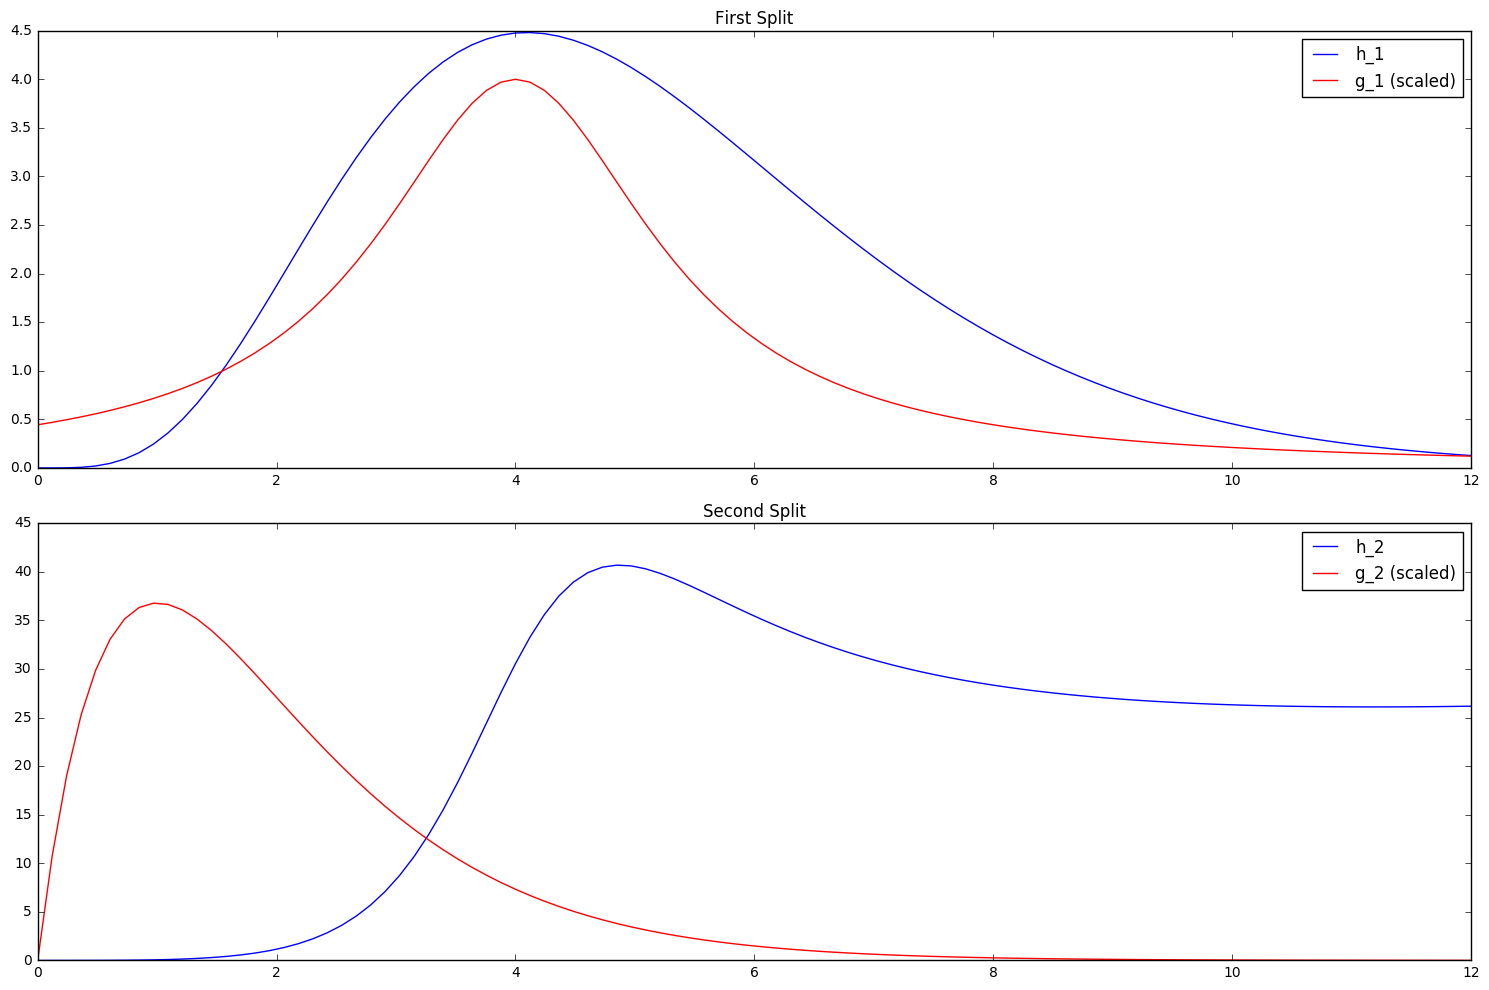

In [27]:
x = np.linspace(0, 12, 100)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.plot(x, h_1(x), color='b', label='h_1')
ax1.plot(x, 8 * np.array(map(g_1, x)), color='r', label='g_1 (scaled)')
ax1.legend(loc='best')
ax1.set_title('First Split')

ax2.plot(x, h_2(x), color='b', label='h_2')
ax2.plot(x, 100 * np.array(map(g_2, x)), color='r', label='g_2 (scaled)')
ax2.legend(loc='best')
ax2.set_title('Second Split')

plt.tight_layout()
plt.show()

We see that $h_2$ is "flatter" than $h_1$ in general, by the simple heuristics we outlined in Part A, we might expect the second split to have lower variance. But on the other hand, the portion of $h_1$ that lies over where $g_1$ has non-negligible probability mass has much less variance than the portion of $h_2$ that lies over where $g_2$ has non-negligible mass. 

The lesson here is that that naively applying our simple heuristics to evaluate splits can be misleading. In almost every case, some elementary computations and/or deeper analyses are needed.

### Monte Carlo Simulation

For the first split, we choose $g(x) = \frac{1}{2 + (x - 4)^2}$. As discussed in the above, we will actually work with a slightly re-defined version of $g$,
$$
\tilde{g}(x) = \begin{cases}
\frac{1}{2 + (x - 4)^2}, & x \geq 0\\
0, & \text{otherwise}
\end{cases}
$$
Note that $I = \int_0^\infty h(x)g(x)dx = \int_{-\infty}^\infty h(x)\tilde{g}(x)dx$.

In [11]:
Z_1, _ = sp.integrate.quad(lambda x: 1. / (2 + (x - 4)**2), 0, np.inf)
print 'normalization constant for first g_tilde: ', Z_1

normalization constant for first g_tilde:  1.98114048591


We will choose normal distributions with variances of 10 for our proposal distribution. We will burn the first 10% of the samples and apply no thinning. 

Then applying Metropolis algorithm to sample from $\tilde{g}$, and to compute $\hat{I}$, is straight-forward:

In [29]:
def metropolis(p, q, total_samples, x_init, burn_in):
    samples = []
    x_prev = x_init
    accepted = 0
    
    for i in range(total_samples):
        x_star = q(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdf_ratio = p_star / p_prev
        
        if np.random.uniform() < min(1, pdf_ratio):
            samples.append(x_star)
            x_prev = x_star
            accepted += 1
        else:
            samples.append(x_prev)
            
    return np.array(samples[int(burn_in * total_samples):]), accepted * 1. / len(samples)

#Monte Carlo 
def monte_carlo(h, Z, p, q, x_init, total_samples, burn_in):
    samples, accept = metropolis(p, q, total_samples, x_init, burn_in)
    print 'accept rate:', accept
    return Z * np.mean(h(samples))

#defining our proposal distribution
sigma = 10
q = lambda x: np.random.normal(x, sigma, 1)[0]

#defining parameters of monte carlo simulation
sims = 50
x_init = 10
total_samples = 150000
burn_in = .1

In [29]:
#simulate 50 times, using first split
means = []
for i in range(sims):
    print 'simulation number:', i
    means.append(monte_carlo(h_1, Z_1, g_1, q, x_init, total_samples, burn_in))

print '*****'
print 'monte carlo estimate of I: ', np.mean(means)
print 'variance of estimate: ', np.var(means)

simulation number: 0
accept rate: 0.265626666667
simulation number: 1
accept rate: 0.27004
simulation number: 2
accept rate: 0.26934
simulation number: 3
accept rate: 0.263826666667
simulation number: 4
accept rate: 0.26562
simulation number: 5
accept rate: 0.264306666667
simulation number: 6
accept rate: 0.263546666667
simulation number: 7
accept rate: 0.263506666667
simulation number: 8
accept rate: 0.26458
simulation number: 9
accept rate: 0.262233333333
simulation number: 10
accept rate: 0.271713333333
simulation number: 11
accept rate: 0.2665
simulation number: 12
accept rate: 0.260793333333
simulation number: 13
accept rate: 0.263526666667
simulation number: 14
accept rate: 0.267666666667
simulation number: 15
accept rate: 0.260093333333
simulation number: 16
accept rate: 0.262566666667
simulation number: 17
accept rate: 0.271706666667
simulation number: 18
accept rate: 0.26614
simulation number: 19
accept rate: 0.26408
simulation number: 20
accept rate: 0.262473333333
simulation

In [13]:
#simulate 50 times, using second split
means = []
for i in range(sims):
    print 'simulation number:', i
    means.append(monte_carlo(h_2, 1., g_2, q, x_init, total_samples, burn_in))

print '*****'
print 'monte carlo estimate of I: ', np.mean(means)
print 'variance of estimate: ', np.var(means)

simulation number: 0
accept rate: 0.142053333333
simulation number: 1
accept rate: 0.14336
simulation number: 2
accept rate: 0.142146666667
simulation number: 3
accept rate: 0.141433333333
simulation number: 4
accept rate: 0.142146666667
simulation number: 5
accept rate: 0.143833333333
simulation number: 6
accept rate: 0.141493333333
simulation number: 7
accept rate: 0.143673333333
simulation number: 8
accept rate: 0.14288
simulation number: 9
accept rate: 0.143006666667
simulation number: 10
accept rate: 0.143273333333
simulation number: 11
accept rate: 0.141
simulation number: 12
accept rate: 0.14384
simulation number: 13
accept rate: 0.142806666667
simulation number: 14
accept rate: 0.143233333333
simulation number: 15
accept rate: 0.14422
simulation number: 16
accept rate: 0.143546666667
simulation number: 17
accept rate: 0.143653333333
simulation number: 18
accept rate: 0.143353333333
simulation number: 19
accept rate: 0.143246666667
simulation number: 20
accept rate: 0.14508
simu

As we expected, the variance of the Monte Carlo estimator for the first split is lower than the variance for the second. 

## Problem 2: Metropolis Algorithm

Suppose we ask you to memorize the order of the top five movies on IMDB. When we quiz you on the order afterwards, you might not recall the correct order, but the mistakes you will tend to make in your recall can be modeled by simple probabilistic models.
  
Let's say that the top five movies are:  
1. *The Shawshank Redemption*
2. *The Godfather*
3. *The Godfather: Part II*
4. *The Dark Knight*
5. *Pulp Fiction*

Let's represent this ordering by the vector $\omega = (1,2,3,4,5)$. 

If you were to mistakenly recall the top five movies as:
2. *The Godfather*
3. *The Godfather: Part II*
5. *Pulp Fiction*
4. *The Dark Knight*
1. *The Shawshank Redemption*

We'd represent your answer by the vector $\theta = (2,3,5,4,1)$.

Now, we have a way of quantifying how wrong your answer can be. We define the Hamming distance between two top five rankings, $\theta, \omega$, as follows:
$$d(\theta, \omega) = \sum_{i=1}^5 \mathbb{I}_{\theta_i\neq \omega_i},$$ 
where $\mathbb{I}_{\theta_i\neq \omega_i}$ is the indicator function that returns 1 if $\theta_i\neq \omega_i$, and 0 otherwise.

For example, the Hamming distance between your answer and the correct answer is $d(\theta, \omega)=4$, because you only ranked *The Dark Knight* is correctly. 

Finally, let's suppose that the probability of giving a particular answer (expressed as $\theta$) is modeled as
$$ p(\theta \,|\, \omega, \lambda) \propto  e^{-\lambda\, d(\theta,\, \omega)}.$$

### Part A:

Implement an Metropolis algorithm to produce sample guesses from 500 individuals, with various $\lambda$ values, $\lambda=0.2, 0.5, 1.0$. What are the top five possible guesses?

**Solutions:**

We will use the same code for the Metropolis step as seen in Problem 1. We will pass, to our Metropolis step function, a set of parameters consisting of a target distribution, a proposal distribution and a set of initializations that are appropriate for this problem.

Before we start sampling, let's build up some intuition for what the sample space and the target distribution looks like. 

Since we are sampling over different orderings of five integers, the sample space is discrete. In fact, there are exactly 5! number of points in our sample space (that is, there are 5! number of possible rankings of 5 movies). The Hamming distance or edit distance imposes a metric on the sample space, giving us a sense of the closeness or similarity of a pair of samples. In particular, we can measure how close a point (representing a ranking of the top five movie) is to $\omega$, the correct ranking. The more a particular ranking doesn't match up (position by position) with $\omega$ the greater the Hamming distance, thus the farther apart we consider consider these two points in the sample space.

Since we have that $e^{-\lambda\, d(\theta_1,\, \omega)}< e^{-\lambda\, d(\theta_2,\, \omega)}$ whenever $d(\theta_1,\, \omega) > d(\theta_2,\, \omega)$, we see that our target distribution
$$ p(\theta \,|\, \omega, \lambda) \propto  e^{-\lambda\, d(\theta,\, \omega)}$$
says that the closer (in edit or Hamming distance) to the correct answer the more likely an answer is. So this is a symmetric distribution over the sample space, whose peak is located at the correct answer, $\omega$, and who decays exponentially as you move away (in Hamming distance) from $\omega$.

From the math, you can see right away that $\lambda$, the decay rate, controls the "peakiness" of the target distribution. That is, the larger the $\lambda$ the more the probability mass is concentrated around the correct answer (and thus the less likely that you would guess a totally wrong answer).

Now let's sample from this distribution (i.e. generate random guesses) to see if our conclusions based on the analysis of the mathematics can be observed in the data.

Before we continue, let's fix a proposal distribution for the Metropolis step. Note that since we've implemented a Metropolis algorithm rather than a Metropolis-Hastings algorithm, we are restricted to choosing proposal distributions that are symmetric. Amongst symmetric distributions, we have quite a lot of flexibility in our choice. However, please keep in mind that there are ***some*** criteria that our proposal distribution, $q$, need to satisfy in order to preserve detailed balance; in particular, a finite or countable union of the support of each $q(\theta_{proposal} | \theta_{current})$ must cover the support of the target distribution. In our case, this is just a fancy way of saying that we can get to any point in the sample space starting off at any other point using our proposal distribution. 

To keep things simple, we will let our proposal distribution be a uniform distribution over the sample space (i.e. we propose each ranking with equal likelihood). But how does one sample uniformly from the sample space? Since each ranking in the sample space differs from another by a permutation, a way to sample uniformly from the space given a particular ranking is to apply a (uniformly) random permutation to the ranking. That is,

$$ \theta_{proposal} = \sigma(\theta_{current})$$

where $\sigma$ is a random permutation.

In [30]:
#the correct answer
omega = np.array([1, 2, 3, 4, 5])
#proposal distribution
proposal = lambda theta: np.random.permutation(theta)
#Hamming distance from correct answer
d = lambda theta: len((theta - omega)[(theta - omega) != 0])
#target distribution in terms of theta and lambda
target_joint = lambda theta, l: np.e**(-l * d(theta))
#total number of guesses to simulate
total_samples = 500
#initial guess
x_init = np.array([2, 1, 3, 5, 4])

#lambdas to try
lambdas = [0.2, 0.5, 1.0]

#simulate 500 guesses for each lambda value
for l in lambdas:
    target = partial(target_joint, l=l)    
    print 'lambda = ', l
    
    #sample
    samples, accept = metropolis(target, proposal, total_samples, x_init, 0)
    print 'accept percent:', accept
    
    #get top 5 guesses in sample
    samples = [np.array_str(s) for s in samples]    
    vals, counts = np.unique(samples, return_counts=True)
    top_5 = counts.argsort()[-5:][::-1]
    
    print 'top 5 guesses:', vals[top_5]
    print 'guess frequencies:', counts[top_5]
    print '\n\n'

lambda =  0.2
accept percent: 0.918
top 5 guesses: ['[5 4 2 3 1]' '[4 2 1 5 3]' '[1 5 3 4 2]' '[1 2 5 3 4]' '[5 1 3 4 2]']
guess frequencies: [11 11 10  9  9]



lambda =  0.5
accept percent: 0.744
top 5 guesses: ['[5 2 3 4 1]' '[1 2 3 5 4]' '[1 4 3 2 5]' '[4 2 3 1 5]' '[4 2 1 3 5]']
guess frequencies: [22 20 19 13 11]



lambda =  1.0
accept percent: 0.29
top 5 guesses: ['[1 2 3 4 5]' '[1 2 5 4 3]' '[1 2 4 3 5]' '[1 4 3 2 5]' '[3 2 5 4 1]']
guess frequencies: [192  23  21  17  16]





So the larger the lambda, the more likely you're to guess the right answer and the more tightly your guesses will cluster around the right answer.

### Part B:
Compute the probability that *The Shawshank Redemption* is ranked as the top movie (ranked number 1) by the Metropolis algorithm sampler. Compare the resulting probabilities for the various different $\lambda$ values. Summarize your findings.

**Solutions:**

To compute $p(\text{shawshank is top} | lambda)$, we count how many guesses have 1 in the first entry.

In [24]:
for l in lambdas:
    target = partial(target_joint, l=l)
    print 'lambda = ', l
    
    #sample
    samples, accept = metropolis(target, proposal, total_samples, x_init, 0)
    #get top ranked movie for samples
    top_guesses = samples[:, 0]
    
    print 'p(shawshank ranked top | lambda)=', len(top_guesses[top_guesses == 1])  * 1. / len(samples)
    print '\n\n'
   

lambda =  0.2
p(shawshank ranked top | lambda)= 0.294



lambda =  0.5
p(shawshank ranked top | lambda)= 0.336



lambda =  1.0
p(shawshank ranked top | lambda)= 0.494





So, $p(\text{shawshank is top} | lambda)$ increases as lambda increases. That is, as labmda increases, your chance of guessing the correct top movie increases.